# Spatial Interpolation at Estero Bay

This document includes Python codes that conduct spatial interpolation for water quality data.

If you are running the code in ArcGIS Notebook, you'll need to install the following packages:

`conda install -c anaconda pandas scikit-learn
conda install -c conda-forge geopandas rasterio contextily
`

**Note: installation of geopandas may take a few hours**

All date are shared in the [box folder](https://usf.box.com/s/xu3dw4i1emv2hzveyf9idnx9q78t939c).

# Table of Contents:

* [1.Load Data](#load_data)
* [2. Preprocess](#preprocess)
* [3. Combine Data](#read_data)
* [4. Spatial Interpolation of Dissolved Oxygen](#do_interpolate)
    * [4.1 Kriging:Dissolved Oxygen](#do_kriging)
    * [4.2 IDW:Dissolved Oxygen](#do_idw)
    * [4.3 Empirical Bayesian Kriging:Dissolved Oxygen](#do_ebk)
    * [4.4 Validation Summary:Dissolved Oxygen](#do_val_sum) 
* [5. Spatial Interpolation of Salinity](#s_interpolate)
    * [5.1 Kriging:Dissolved Oxygen](#s_kriging)
    * [5.2 IDW:Dissolved Oxygen](#s_idw)
    * [5.3 Empirical Bayesian Kriging:Dissolved Oxygen](#s_ebk)
    * [5.4 Regression Kriging:Dissolved Oxygen](#s_rk)
* [6. Spatial Interpolation of Total Nitrogen](#tn_interpolate)
    * [6.1 Kriging:Total Nitrogen](#tn_kriging)
    * [6.2 IDW:Total Nitrogen](#tn_idw)
    * [6.3 Empirical Bayesian Kriging:Total Nitrogen](#tn_ebk)
    * [6.4 Regression Kriging:Total Nitrogen](#tn_rk)
* [7. Spatial Interpolation of Turbidity](#t_interpolate)
    * [7.1 Kriging:Turbidity](#t_kriging)
    * [7.2 IDW:Turbidity](#t_idw)
    * [7.3 Empirical Bayesian Kriging:Turbidity](#t_ebk)
    * [7.4 Regression Kriging:Turbidity](#t_rk)
* [8. Spatial Interpolation of Secchi Depth](#sd_interpolate)
    * [8.1 Kriging:Secchi Depth](#sd_kriging)
    * [8.2 IDW:Secchi Depth](#sd_idw)
    * [8.3 Empirical Bayesian Kriging:Secchi Depth](#sd_ebk)
    * [8.4 Regression Kriging:Secchi Depth](#sd_rk)

In [19]:
import time, math, os, importlib
import sklearn.metrics  
import arcgisscripting
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask
import rasterio.plot as rio_pl
import matplotlib.image as mpimg
#import rioxarray as rxr

from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.mask import mask
from rasterio import MemoryFile
from rasterio.profiles import DefaultGTiffProfile
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.stats import sem
from sklearn.metrics import mean_squared_error
from shapely.geometry import box, Polygon, Point
from shapely import wkt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import contextily as cx
#from osgeo import gdal
#from pykrige.ok import OrdinaryKriging

# import arcpy and environmental settings
import arcpy
from arcpy.sa import *
import sys
sys.path.append('..')
import misc.preprocess
import misc.interpolation
arcpy.env.overwriteOutput = True

# 1. Load and Preprocess Data <a class="anchor" id="load_data"></a>

In [20]:
path = "E:/Projects/SEACAR_WQ_Pilot/"
gis_path = path+'GIS_data/'

# path = "D:/Water_Quailty/"
# gis_path = path+'Test02200/'

Preprocess the data and save the preprocessed data in new files

In [21]:
# dfDis, dfCon = misc.preprocess.preprocess(path + r"OEAT_Discrete-2023-Jan-23.csv", 
#                     path + r"OEAT_Continuous_1-2023-Jan-23.csv",
#                     path + r"OEAT_Continuous_2-2023-Jan-23.csv")

# dfDis.to_csv(path + "discrete_0214.csv")
# dfCon.to_csv(path + "continuous_0214.csv")

To save time, we can load the preprocessed "discrete_0214.csv" and "continuous_0214.csv".

In [22]:
#dfDis = pd.read_csv("D:/Water_Quailty/Test0214/discrete_0214.csv")
#dfCon = pd.read_csv("D:/Water_Quailty/Test0214/continuous_0214.csv")

dfDis = pd.read_csv(path + "discrete_0214.csv")
dfCon = pd.read_csv(path + "continuous_0214.csv")

In [23]:
col_ls = ['RowID','ParameterName','ParameterUnits','ProgramLocationID','ActivityType','ManagedAreaName',
                   'SampleDate','Year','Month','ResultValue','ValueQualifier','Latitude_DD','Longitude_DD']
para_ls = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"]
para_ls_ab = ["S","TN","DO","T","SD"]
# Convert full MA names to short names
dictArea    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'GTM Reserve','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass AP',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island'}

# Convert full MA names to MA name in ORCP_Managed_Areas_Oct2021
dictArea2    = {'Gasparilla Sound-Charlotte Harbor Aquatic Preserve':'Gasparilla Sound-Charlotte Harbor','Big Bend Seagrasses Aquatic Preserve':'Big Bend Seagrasses',
                'Guana Tolomato Matanzas National Estuarine Research Reserve':'Guana Tolomato Matanzas NERR','Estero Bay Aquatic Preserve':'Estero Bay',
                'Biscayne Bay Aquatic Preserve':'Biscayne Bay','Matlacha Pass Aquatic Preserve':'Matlacha Pass',
                'Lemon Bay Aquatic Preserve':'Lemon Bay','Cape Haze Aquatic Preserve':'Cape Haze','Pine Island Sound Aquatic Preserve':'Pine Island Sound'}

dictUnits   = {"Salinity":"ppt","Total Nitrogen": "mg/L","Dissolved Oxygen": "mg/L","Turbidity": "NTU", "Secchi Depth": "m"}
listArea    = dfCon["ManagedAreaName"].unique()
listPara    = ["Salinity","Total Nitrogen","Dissolved Oxygen","Turbidity","Secchi Depth"] 

# Set variables of the program
year = "2017"
Area = 'Estero Bay Aquatic Preserve'
Para = 'Dissolved Oxygen'
Para_ab = "DO"
SpatialRef = '3086'
b_name = 'eb'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'
boundary_shp = gis_path+ '{}.shp'.format(b_name)


# 2. Combine Discrete and Continuous Data <a class="anchor" id="combine"></a>

Combine dis and con dataframes

In [24]:
# ---------------------------- Uncomment in the first run --------------------------
dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\3578914940.py:11: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\3578914940.py:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


Skip the preprocessing and load the pre-stored dataframes

In [25]:
# gdfDryAll = pd.read_csv(gis_path+'gdfDryAll{}.csv'.format(year))
# gdfDryAll['geometry'] = gdfDryAll['geometry'].apply(wkt.loads)
# gdfDryAll = gpd.GeoDataFrame(gdfDryAll, crs='epsg:'+SpatialRef)

# gdfWetAll = pd.read_csv(gis_path+'gdfWetAll{}.csv'.format(year))
# gdfWetAll['geometry'] = gdfWetAll['geometry'].apply(wkt.loads)
# gdfWetAll = gpd.GeoDataFrame(gdfWetAll, crs='epsg:'+SpatialRef)

# 3. Read Input Data <a class="anchor" id="read_data"></a>
## 3.1 Load Managed Area Polygon

In [26]:
#MA = gpd.read_file(r"D:\Water_Quailty\ManagedAreas\ORCP_Managed_Areas_Oct2021.shp")
MA = gpd.read_file(gis_path + r"ORCP_Managed_Areas_Oct2021.shp")
CH = MA[MA['MA_Name']==dictArea2[Area]].to_crs(int(SpatialRef))
CH.to_file(boundary_shp , driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

extentShp = gpd.read_file(boundary_shp )
extent = str(extentShp.geometry.total_bounds).replace('[','').replace(']','')

## 3.2 Load Point Shapefiles

Also convert all shapefile to Florida GDL Albers (https://epsg.io/3086)

In [27]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

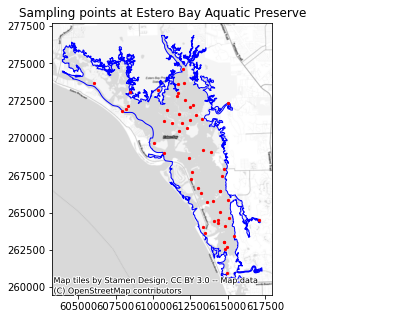

In [28]:
fig, ax = plt.subplots(figsize = (9,5))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))


# 4. Spatial Interpoation of Dissolved Oxygen <a class="anchor" id="do_interpolate"></a>

## 4.1 Ordinary Kriging: Dissolved Oxygen <a class="anchor" id="do_kriging"></a>

Run Oridinary Kriging for dry season data

In [29]:
season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

Start the interpolation with the OK method


'Validation of the OK method in the dry season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
OK   0.050466               0.036613             1.124769

Start the interpolation with the OK method


'Validation of the OK method in the wet season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
OK   0.065124               0.046181             0.966123

Plot the interpolation result

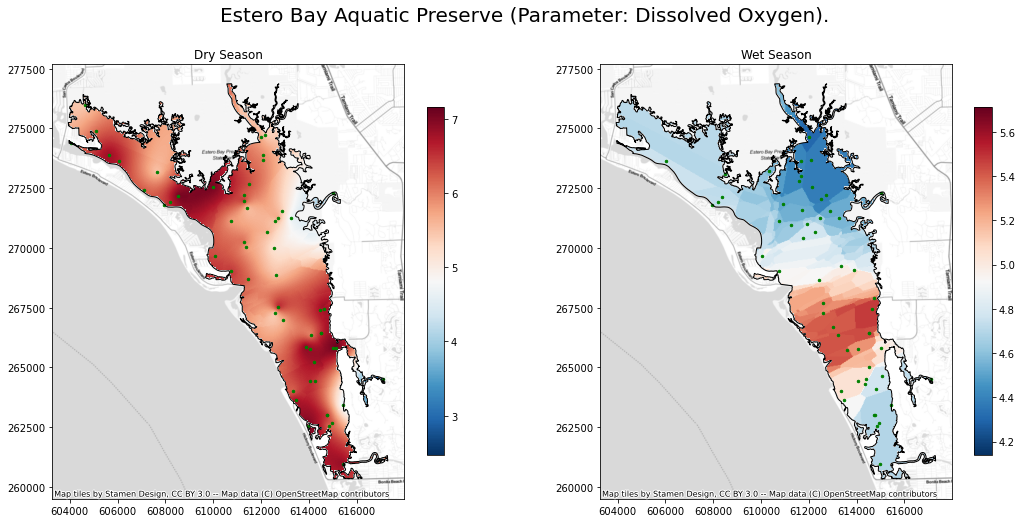

In [30]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 4.2 Inverse Distance Weighting (IDW): Dissolved Oxygen <a class="anchor" id="do_idw"></a>

Run IDW for both wet and dry seasons

In [31]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

Start the interpolation with the IDW method
--- Time lapse: 12.83086895942688 seconds ---


'Validation of the IDW method in the dry season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
IDW     0.1879                    NaN               1.2033

Start the interpolation with the IDW method
--- Time lapse: 13.162355422973633 seconds ---


'Validation of the IDW method in the wet season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
IDW     0.1656                    NaN                1.079

Plot the interpolation result

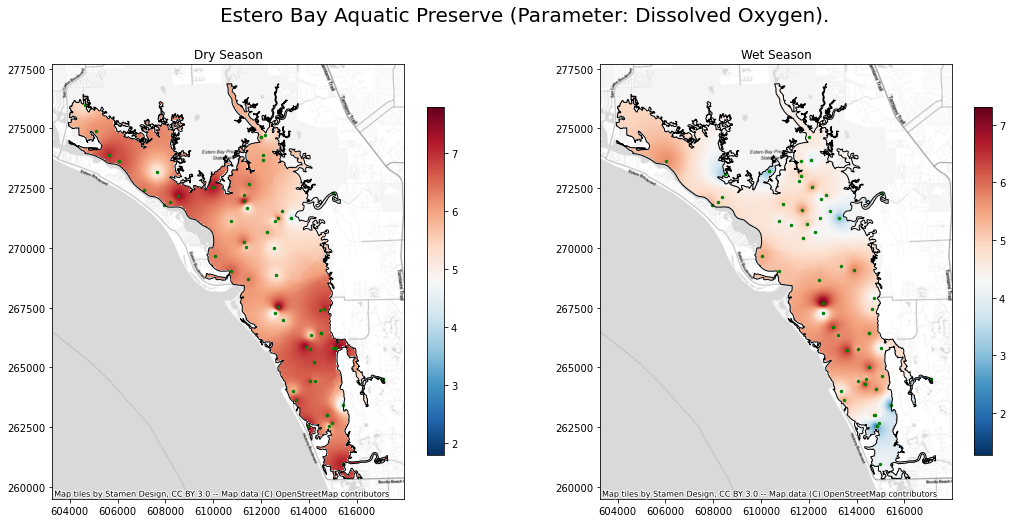

In [32]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)


## 4.3 Empirical Bayesian Kriging (EBK) <a class="anchor" id="do_ebk"></a>

Run EBK for wet and dry seasons

In [34]:
season, method, value_field, mask =  'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

Start the interpolation with the EBK method
--- Time lapse: 60.04456090927124 seconds ---


'Validation of the EBK method in the dry season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
EBK     0.0439                 0.0191               1.0754

Start the interpolation with the EBK method
--- Time lapse: 58.269824743270874 seconds ---


'Validation of the EBK method in the wet season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
EBK     0.0166                 0.0064               0.9456

Plot interpolation results

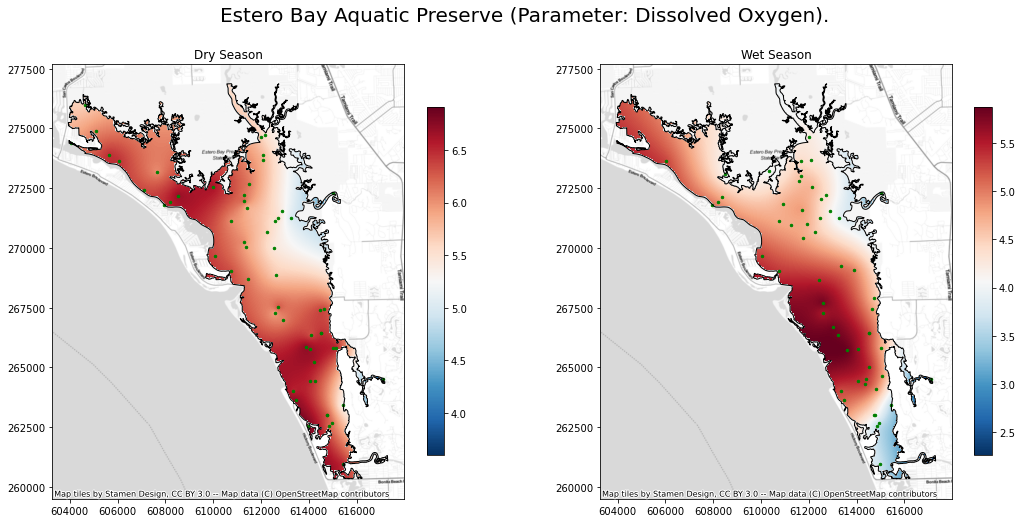

In [35]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)


## 4.4 Validation summary <a class="anchor" id="do_ebk_sum"></a>

In [36]:
sumStatDry1   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry1

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
OK    0.050466               0.036613             1.124769
IDW   0.187900                    NaN             1.203300
EBK   0.043900               0.019100             1.075400

In [37]:
sumStatWet1 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet1

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
OK    0.065124               0.046181             0.966123
IDW   0.165600                    NaN             1.079000
EBK   0.016600               0.006400             0.945600

# 5. Spatial Interpolation of Salinity <a class="anchor" id="s_interpolate"></a>

In [38]:

# dfDis["timestamp"]=  pd.to_datetime(dfDis['SampleDate'])
# dfCon["timestamp"]=  pd.to_datetime(dfCon['SampleDate'])

# dfDryMean, gdfDryAll = combine_dis_con_dry(dfDis,dfCon,year)
# dfWetMean, gdfWetAll = combine_dis_con_wet(dfDis,dfCon,year)

Para, Para_ab = 'Salinity', 'S'

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\3782005919.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\3782005919.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [39]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

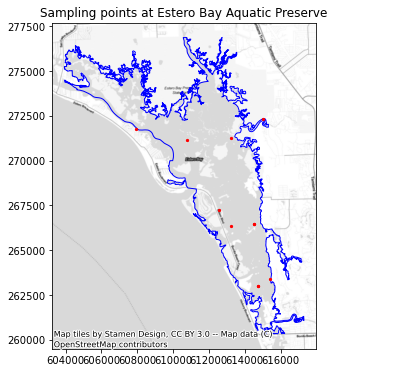

In [40]:
fig, ax = plt.subplots(figsize = (9,6))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 5.1 Ordinary Kriging (Salinity) <a class="anchor" id="s_ok"></a>

In [41]:
season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

Start the interpolation with the OK method


'Validation of the OK method in the dry season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
OK   0.730991               0.147041             4.518262

Start the interpolation with the OK method


'Validation of the OK method in the wet season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
OK   0.968348               0.104999             7.495195

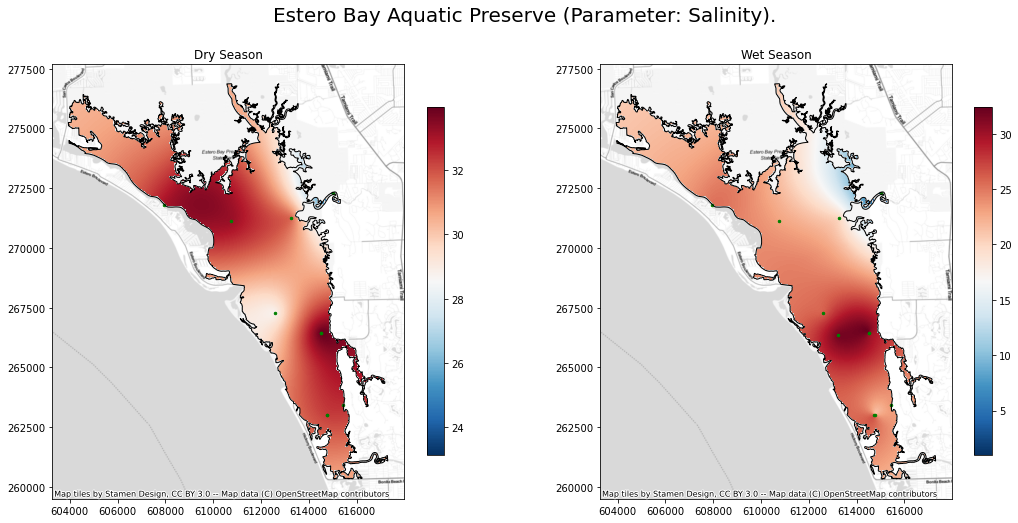

In [42]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 5.2 Inverse Distance Weighting (IDW): Salinity <a class="anchor" id="s_idw"></a>

Run IDW for both wet and dry seasons

In [43]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

Start the interpolation with the IDW method
--- Time lapse: 14.01746153831482 seconds ---


'Validation of the IDW method in the dry season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
IDW     0.8729                    NaN               4.3423

Start the interpolation with the IDW method
--- Time lapse: 13.531759977340698 seconds ---


'Validation of the IDW method in the wet season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
IDW     1.5372                    NaN                 7.55

Plot the interpolation result

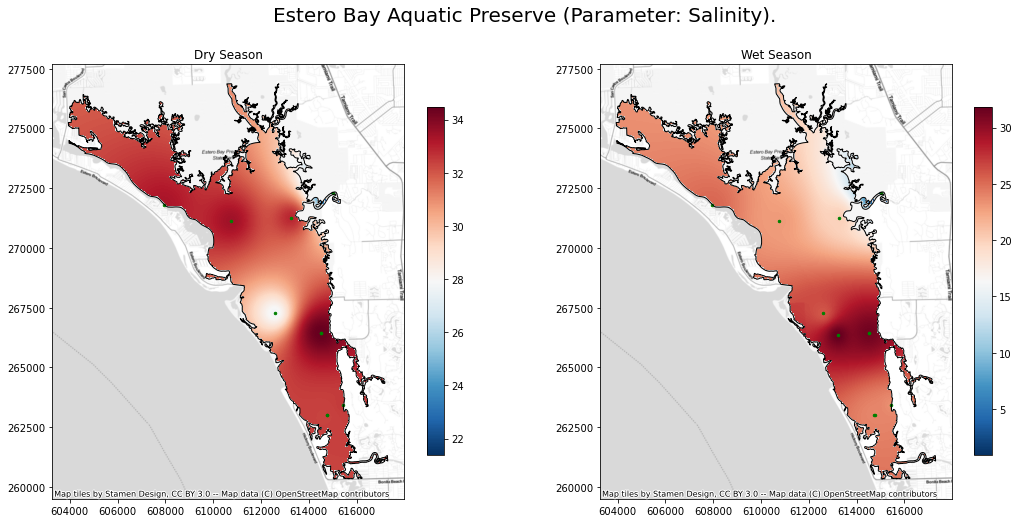

In [44]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)

## 5.3 Empirical Bayesian Kriging (EBK): Salinity <a class="anchor" id="s_ebk"></a>

Run EBK for wet and dry seasons

In [45]:
season, method, value_field, mask = 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

Start the interpolation with the EBK method
--- Time lapse: 15.322314023971558 seconds ---


'Validation of the EBK method in the dry season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
EBK     0.9506                 0.1466               4.7265

Start the interpolation with the EBK method
--- Time lapse: 16.12339472770691 seconds ---


'Validation of the EBK method in the wet season in 2017:'

meanError  meanStandardizedError  rootMeanSquareError
EBK     0.9941                 0.0714               7.1427

Plot interpolation results

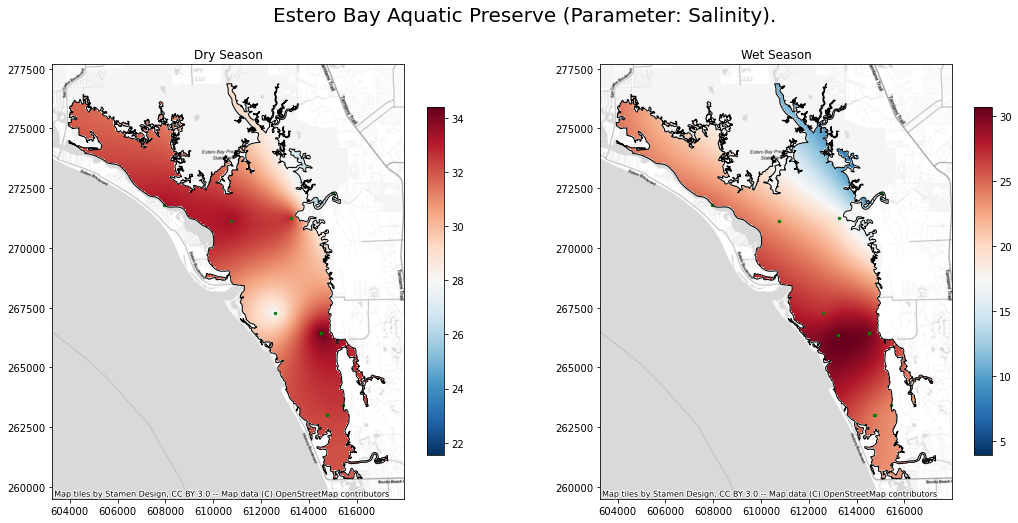

In [46]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)

## 5.4 Validation Summary: Salinity <a class="anchor" id="s_val_sum"></a>

In [47]:
sumStatDry2   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry2

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
OK    0.730991               0.147041             4.518262
IDW   0.872900                    NaN             4.342300
EBK   0.950600               0.146600             4.726500

In [48]:
sumStatWet2 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet2

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
OK    0.968348               0.104999             7.495195
IDW   1.537200                    NaN             7.550000
EBK   0.994100               0.071400             7.142700

# 6. Spatial Interpolation of Total Nitrogen <a class="anchor" id="tn_interpolate"></a>

Select and preview data

In [49]:
year,Para,Para_ab = "2014", 'Total Nitrogen', "TN"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\4272777287.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\4272777287.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [50]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

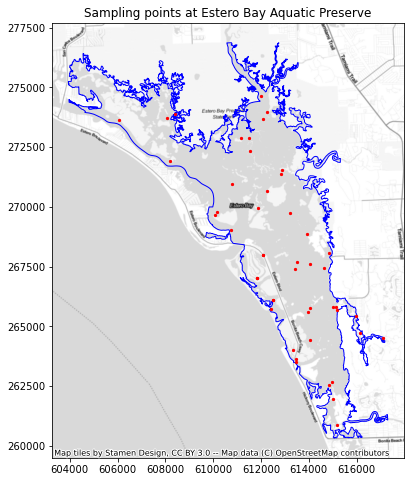

In [51]:
fig, ax = plt.subplots(figsize = (9,8))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 6.1 Ordinary Kriging: Total Nitrogen <a class="anchor" id="tn_kriging"></a>

In [52]:
season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

Start the interpolation with the OK method


'Validation of the OK method in the dry season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
OK  -0.007127              -0.014898             0.194357

Start the interpolation with the OK method


'Validation of the OK method in the wet season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
OK  -0.003195              -0.013377             0.227133

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


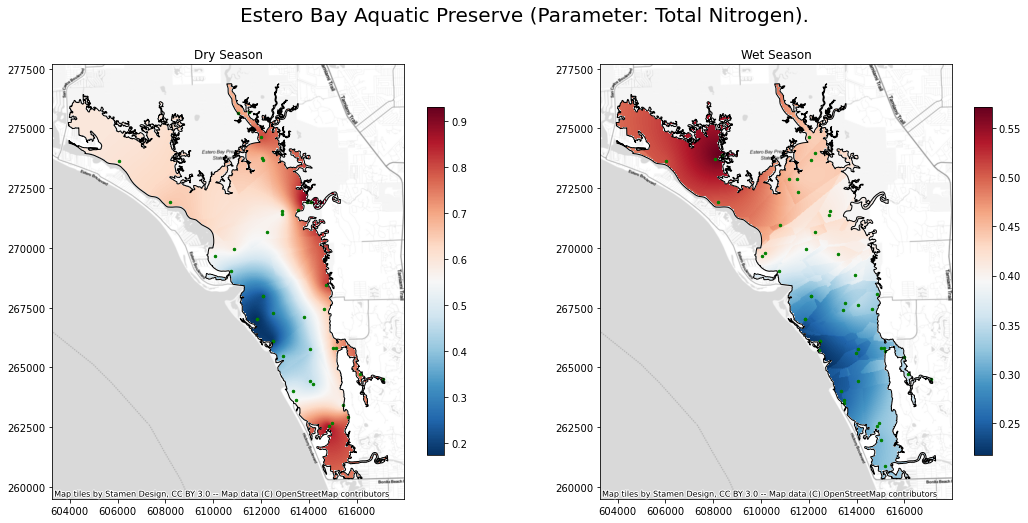

In [53]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 6.2 Inverse Distance Weighting: Total Nitrogen <a class="anchor" id="tn_idw"></a>

In [54]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

Start the interpolation with the IDW method
--- Time lapse: 33.34491991996765 seconds ---


'Validation of the IDW method in the dry season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
IDW    -0.0357                    NaN               0.2212

Start the interpolation with the IDW method
--- Time lapse: 35.724563121795654 seconds ---


'Validation of the IDW method in the wet season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
IDW     0.0058                    NaN               0.2833

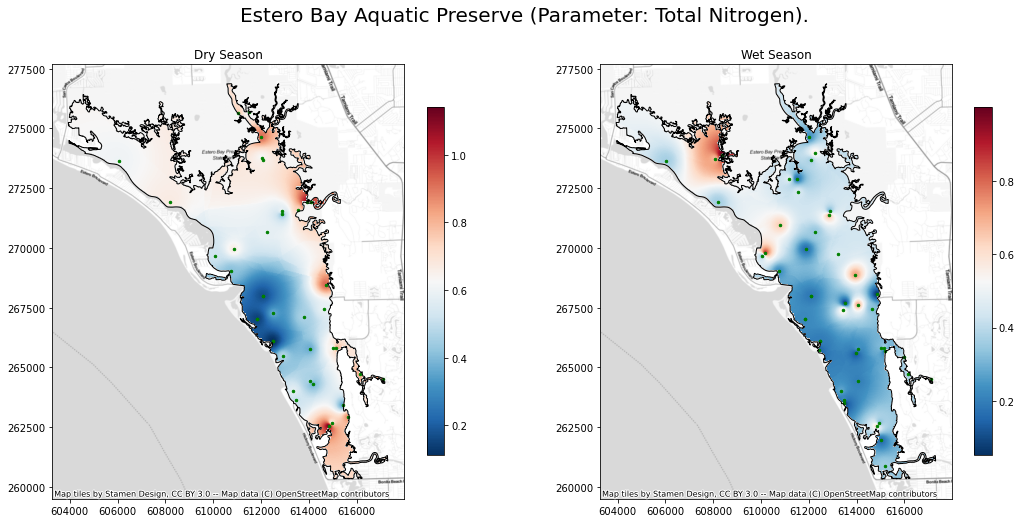

In [55]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)

## 6.3 Empirical Bayesian Kriging: Total Nitrogen <a class="anchor" id="tn_ebk"></a>

In [56]:
season, method, value_field, mask = 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

Start the interpolation with the EBK method
--- Time lapse: 69.4325110912323 seconds ---


'Validation of the EBK method in the dry season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
EBK     -0.006                -0.0126               0.1905

Start the interpolation with the EBK method
--- Time lapse: 71.3334288597107 seconds ---


'Validation of the EBK method in the wet season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
EBK    -0.0011                 -0.003               0.2237

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


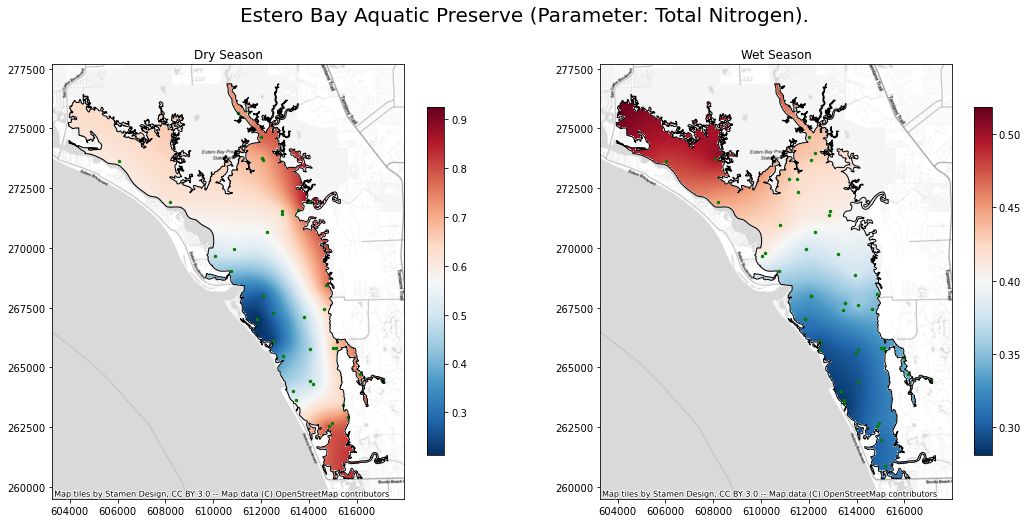

In [57]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)

## 6.4 Validation Summary: Total Nitrogen <a class="anchor" id="tn_rk_val"></a>

In [58]:
sumStatDry3   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry3

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
OK   -0.007127              -0.014898             0.194357
IDW  -0.035700                    NaN             0.221200
EBK  -0.006000              -0.012600             0.190500

In [59]:
sumStatWet3 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet3

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
OK   -0.003195              -0.013377             0.227133
IDW   0.005800                    NaN             0.283300
EBK  -0.001100              -0.003000             0.223700

# 7. Spatial Interpolation of Turbidity <a class="anchor" id="t_interpolate"></a>

Select and preview data

In [60]:
year,Para,Para_ab = "2014", 'Turbidity', "T"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\2848871626.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\2848871626.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [61]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

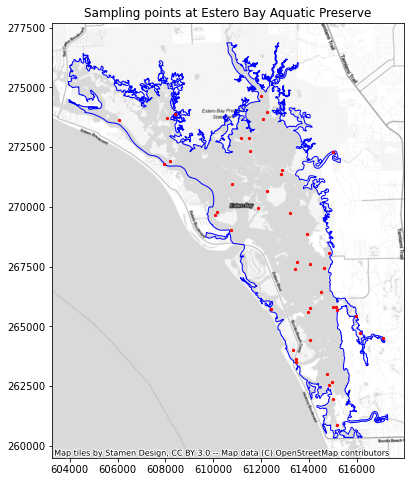

In [62]:
fig, ax = plt.subplots(figsize = (9,8))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 7.1 Ordinary Kriging: Turbidity <a class="anchor" id="t_kriging"></a>

In [63]:
season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

Start the interpolation with the OK method


'Validation of the OK method in the dry season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
OK   0.050936               0.019269             2.133367

Start the interpolation with the OK method


'Validation of the OK method in the wet season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
OK  -0.172852              -0.070781             1.659817

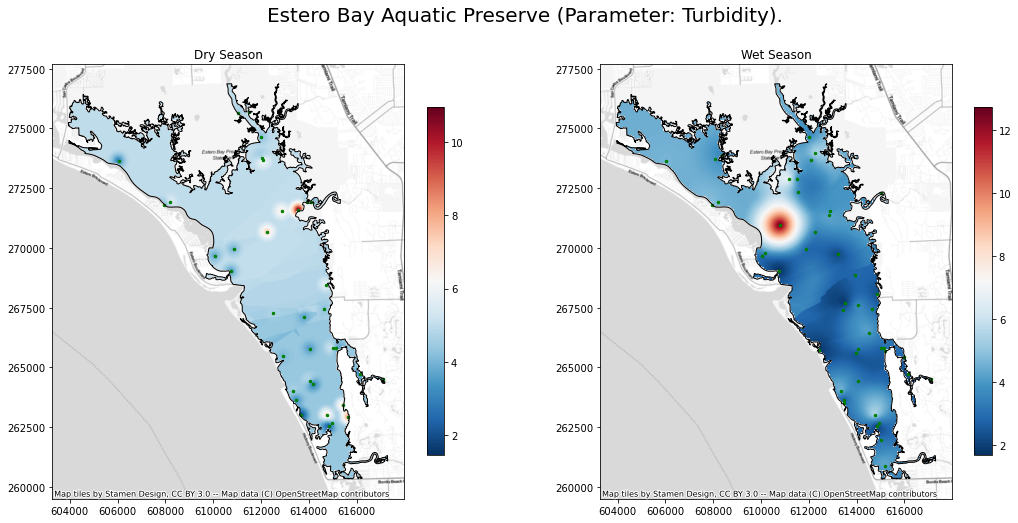

In [64]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 7.2 Inverse Distance Weighting: Turbidity <a class="anchor" id="t_idw"></a>

In [65]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

Start the interpolation with the IDW method
--- Time lapse: 25.69733738899231 seconds ---


'Validation of the IDW method in the dry season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
IDW    -0.0783                    NaN               2.0975

Start the interpolation with the IDW method
--- Time lapse: 24.67307424545288 seconds ---


'Validation of the IDW method in the wet season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
IDW    -0.1004                    NaN               1.7086

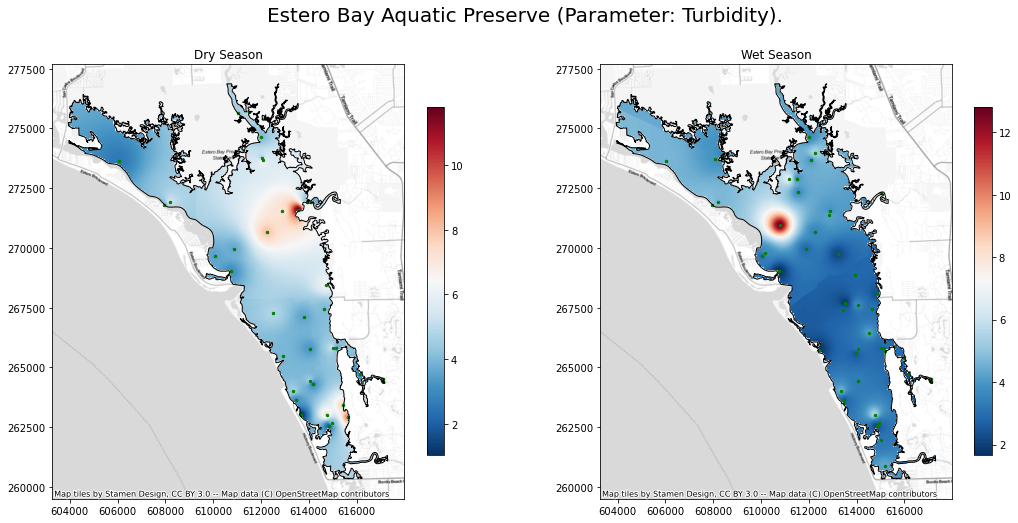

In [66]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)

## 7.3 Empirical Bayesian Kriging: Turbidity <a class="anchor" id="t_ebk"></a>

In [67]:
season, method, value_field, mask = 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

Start the interpolation with the EBK method
--- Time lapse: 42.955225706100464 seconds ---


'Validation of the EBK method in the dry season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
EBK     0.0394                 0.0165               2.2109

Start the interpolation with the EBK method
--- Time lapse: 67.07078981399536 seconds ---


'Validation of the EBK method in the wet season in 2014:'

meanError  meanStandardizedError  rootMeanSquareError
EBK    -0.0433                 -0.016               1.6778

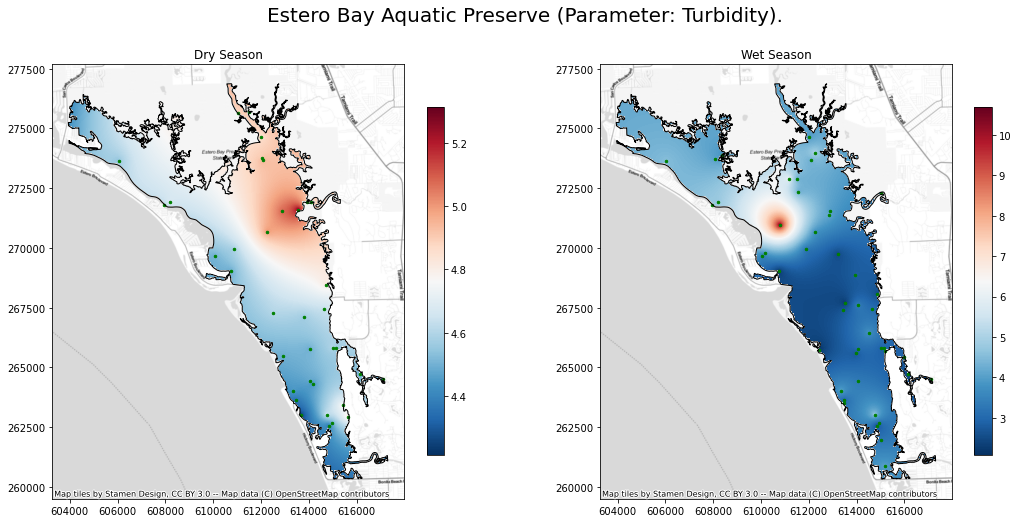

In [68]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)

## 7.4 Validation Summary: Turbidity <a class="anchor" id="t_rk_val"></a>

In [69]:
sumStatDry4   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry4

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
OK    0.050936               0.019269             2.133367
IDW  -0.078300                    NaN             2.097500
EBK   0.039400               0.016500             2.210900

In [70]:
sumStatWet4 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet4

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
OK   -0.172852              -0.070781             1.659817
IDW  -0.100400                    NaN             1.708600
EBK  -0.043300              -0.016000             1.677800

# 8. Spatial Interpolation of Secchi Depth <a class="anchor" id="sd_interpolate"></a>

Select and preview data

In [80]:
year,Para,Para_ab = "2006", 'Secchi Depth', "SD"

dry_input_pt = gis_path+"Dry"+year+Para_ab+b_name+'.shp'
wet_input_pt = gis_path+"Wet"+year+Para_ab+b_name+'.shp'

dfDryMean, gdfDryAll = misc.preprocess.combine_dis_con_dry(dfDis,dfCon,year)
dfWetMean, gdfWetAll = misc.preprocess.combine_dis_con_wet(dfDis,dfCon,year)

gdfDryAll.to_csv(gis_path+'gdfDryAll{}.csv'.format(year))
gdfWetAll.to_csv(gis_path+'gdfWetAll{}.csv'.format(year))

gdfDrySelect = gdfDryAll[(gdfDryAll["ParameterName"]==Para)&(gdfDryAll["ManagedAreaName"]==Area)]
gdfWetSelect = gdfWetAll[(gdfWetAll["ParameterName"]==Para)&(gdfWetAll["ManagedAreaName"]==Area)]

gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)

C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\1825365313.py:15: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfDrySelect.to_crs(int(SpatialRef)).to_file(dry_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)
C:\Users\qiangy\AppData\Local\Temp\ipykernel_14116\1825365313.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdfWetSelect.to_crs(int(SpatialRef)).to_file(wet_input_pt, driver='ESRI Shapefile',crs="EPSG:"+SpatialRef)


In [83]:
gdfDryShp = gpd.read_file(dry_input_pt)
gdfWetShp = gpd.read_file(wet_input_pt)
extentShp = gpd.read_file(boundary_shp)

Text(0.5, 1.0, 'Sampling points at Estero Bay Aquatic Preserve')

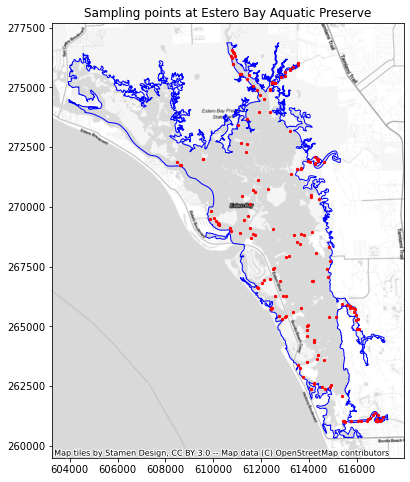

In [84]:
fig, ax = plt.subplots(figsize = (9,8))
extentShp.plot(ax = ax, color='none', edgecolor='blue')
gdfWetShp.plot(ax = ax, marker='o', color='red', markersize=5)
cx.add_basemap(ax = ax,source=cx.providers.Stamen.TonerLite,crs=gdfDryShp.crs)
ax.set_title('Sampling points at {}'.format(Area))

## 8.1 Ordinary Kriging: Secchi Depth <a class="anchor" id="sd_kriging"></a>

In [85]:
season, method, value_field, mask = 'Dry','ok','ResultValu', boundary_shp 
in_features = dry_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryOK, dryOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryOKStat)

season = 'Wet'
in_features = wet_input_pt 
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetOK,wetOKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetOKStat)

Start the interpolation with the OK method


'Validation of the OK method in the dry season in 2006:'

meanError  meanStandardizedError  rootMeanSquareError
OK  -0.002049               0.001919             0.312591

Start the interpolation with the OK method


'Validation of the OK method in the wet season in 2006:'

meanError  meanStandardizedError  rootMeanSquareError
OK   0.009131               0.017069             0.393452

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


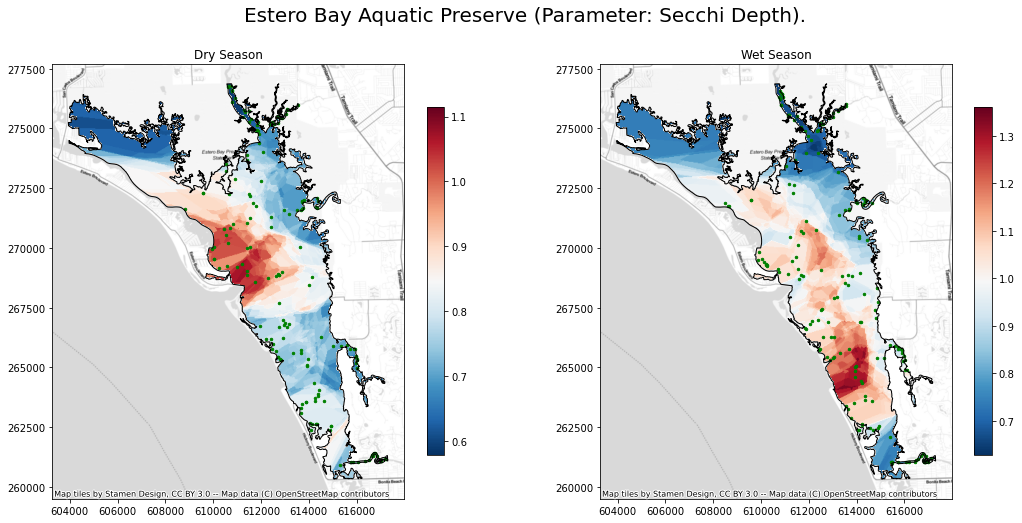

In [86]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryOK, 'Dry Season', axes[0], fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetOK, 'Wet Season', axes[1], fig)

## 8.2 Inverse Distance Weighting: Secchi Depth <a class="anchor" id="t_idw"></a>

In [87]:
season, method, value_field, mask = 'Dry','idw','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryIDW, dryIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = value_field, 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryIDWStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetIDW, wetIDWStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                      out_raster = out_raster, z_field = 'ResultValu', 
                      out_ga_layer = out_ga_layer, extent = extent, 
                      mask = mask)
    
display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetIDWStat)

Start the interpolation with the IDW method
--- Time lapse: 30.406793117523193 seconds ---


'Validation of the IDW method in the dry season in 2006:'

meanError  meanStandardizedError  rootMeanSquareError
IDW    -0.0049                    NaN               0.3226

Start the interpolation with the IDW method
--- Time lapse: 29.02166199684143 seconds ---


'Validation of the IDW method in the wet season in 2006:'

meanError  meanStandardizedError  rootMeanSquareError
IDW     0.0162                    NaN               0.4215

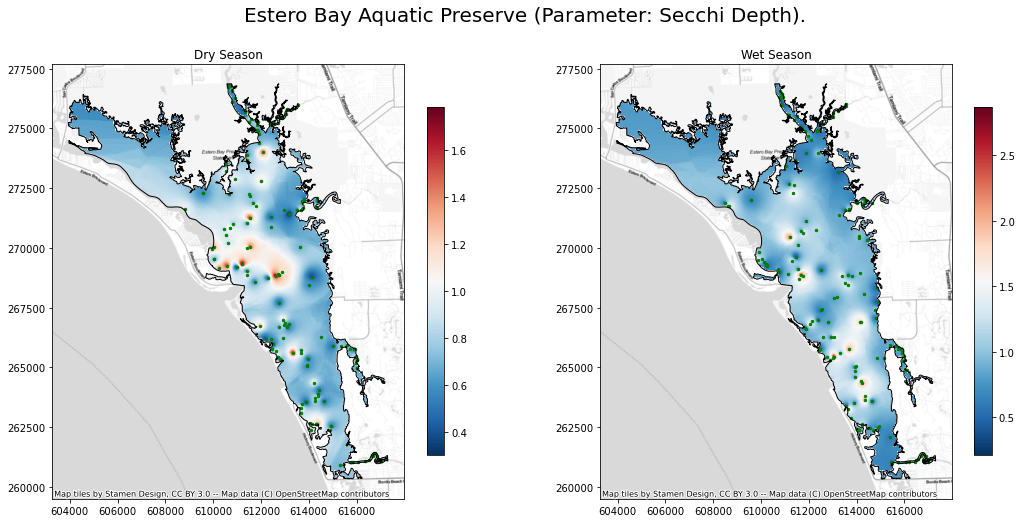

In [88]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryIDW, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetIDW, 'Wet Season', axes[1],fig)

## 8.3 Empirical Bayesian Kriging: Secchi Depth <a class="anchor" id="sd_ebk"></a>

In [90]:
season, method, value_field, mask = 'Dry','ebk','ResultValu', boundary_shp 
in_features = dry_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

dryEBK, dryEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = value_field, 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(dryEBKStat)

season = 'Wet'
in_features = wet_input_pt
out_ga_layer = gis_path +"{}{}{}.lyrx".format(Para_ab, season.lower(), method.upper())
out_raster = gis_path +"{}{}{}.tif".format(Para_ab, season.lower(),method.upper())

wetEBK, wetEBKStat = misc.interpolation.interpolation(method = method, input_point = in_features, 
                                               out_raster = out_raster, z_field = 'ResultValu', 
                                               out_ga_layer = out_ga_layer, extent = extent, mask = mask)

display('Validation of the {} method in the {} season in {}:'.format(method.upper(),season.lower(), year))
display(wetEBKStat)

Start the interpolation with the EBK method
--- Time lapse: 52.30722761154175 seconds ---


'Validation of the EBK method in the dry season in 2006:'

meanError  meanStandardizedError  rootMeanSquareError
EBK     0.0015                 0.0042               0.3022

Start the interpolation with the EBK method
--- Time lapse: 46.233604431152344 seconds ---


'Validation of the EBK method in the wet season in 2006:'

meanError  meanStandardizedError  rootMeanSquareError
EBK     0.0026                 0.0058               0.3805

C:\Users\qiangy\AppData\Local\ESRI\conda\envs\geo3\lib\site-packages\matplotlib\image.py:487: RuntimeWarning: overflow encountered in true_divide
  A_scaled /= ((a_max - a_min) / frac)


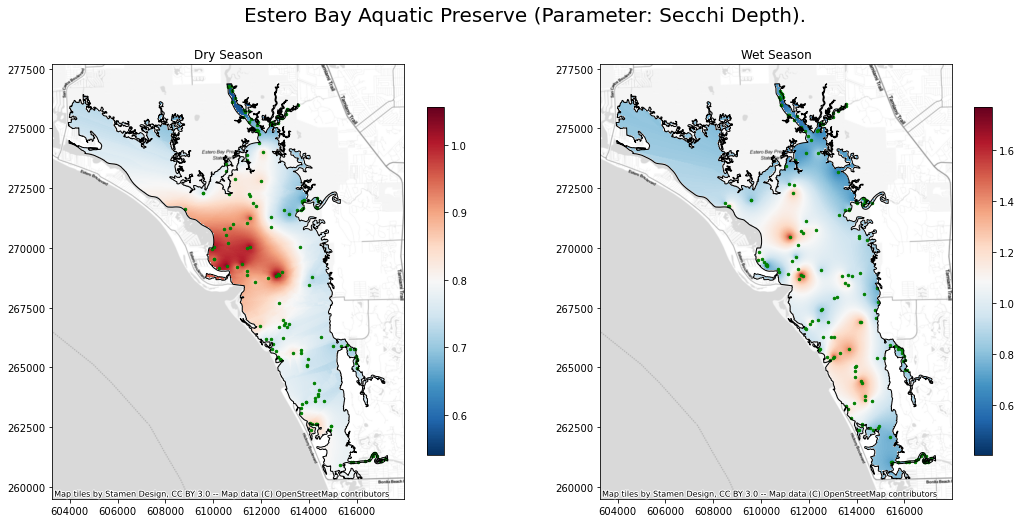

In [91]:
fig, axes = plt.subplots(1,2, figsize=(18, 8))

fig.suptitle("{} (Parameter: {}).".format(Area, Para),fontsize=20)

misc.interpolation.plot_raster(gdfDryShp, extentShp, dryEBK, 'Dry Season', axes[0],fig)
misc.interpolation.plot_raster(gdfWetShp, extentShp, wetEBK, 'Wet Season', axes[1],fig)

## 8.4 Validation Summary: Secchi Depth <a class="anchor" id="sd_rk_val"></a>

In [92]:
sumStatDry5   = pd.concat([dryOKStat,dryIDWStat,dryEBKStat])
print("Summary of interpolation assessment in dry season data")
sumStatDry5

Summary of interpolation assessment in dry season data


meanError  meanStandardizedError  rootMeanSquareError
OK   -0.002049               0.001919             0.312591
IDW  -0.004900                    NaN             0.322600
EBK   0.001500               0.004200             0.302200

In [93]:
sumStatWet5 = pd.concat([wetOKStat,wetIDWStat,wetEBKStat])
print("Summary of interpolation assessment in wet season data")
sumStatWet5

Summary of interpolation assessment in wet season data


meanError  meanStandardizedError  rootMeanSquareError
OK    0.009131               0.017069             0.393452
IDW   0.016200                    NaN             0.421500
EBK   0.002600               0.005800             0.380500